┌ Info: Saved animation to 
│   fn = /Users/sandvik/Courses/py502/Quantum/Examples/a.gif
└ @ Plots /Users/sandvik/.julia/packages/Plots/vVVub/src/animation.jl:104


Plots.AnimatedGif("/Users/sandvik/Courses/py502/Quantum/Examples/a.gif")
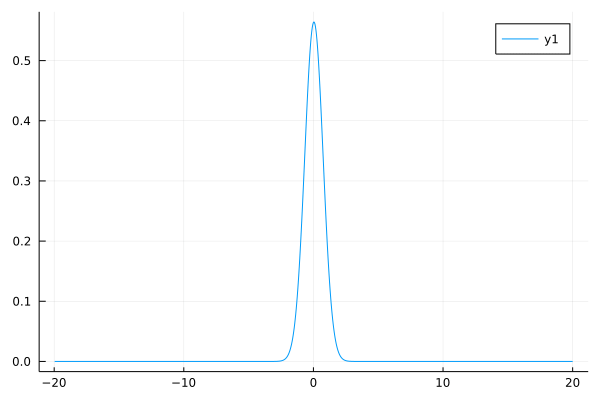

In [47]:
 using FFTW
 using Plots

# Any potential for x between -ll and +ll can be coded here

 function potential(x::Float64,ll::Float64)::Float64
    v::Float64=0
    v=0.
    if abs(abs(x)-ll) < 1. # Walls of width 1 at both ends of the box
       v=500.              # A large value; effectively a hard-wall box
    end
    return v
 end 

# Initializes the potential and kinetic evolution operators
# - these are diagonal matrices and the dia elements are stored as vectors
 function operators(dt::Float64,nn::Int,ll::Float64)
    vdt=Vector{ComplexF64}(undef,nn)   # potential-energy evolution operator
    kdt=Vector{ComplexF64}(undef,nn)   # kinetic-energy evolution operator
    dx::Float64=2*ll/nn
    dk::Float64=2*pi/(2*ll)
    for i=-div(nn,2)+1:div(nn,2)
       x::Float64=i*dx
       k::Float64=i*dk
       i>0 ? j=i : j=i+nn                   # The elements are stored in the
       vdt[j]=exp(-dt*im*potential(x,ll))   # order used in the FT
       kdt[j]=exp(-dt*im*0.5*k^2)
    end
    return vdt,kdt
 end

# Initializes a wave packet in momentum space
# Inverse Fourier trandform to real space at the end and normalizes

 function initpacket(nn::Int,ll::Float64,a0::Float64,k0::Float64)
    psi=Vector{ComplexF64}(undef,nn)
    dk=pi/ll
    for i=-div(nn,2)+1:div(nn,2)
       k=i*dk
       i>0 ? j=i : j=i+nn
       psi[j]=exp(-0.5*(a0*(k-k0))^2)
    end
    psi=ifft(psi)
    r::Float64=sum(abs2.(psi))
    psi.*=1/sqrt(r*2*ll/nn)
    return psi
 end

# Initializes a wave packet in real space (centered at x=x0)

 function xinitpacket(nn::Int,ll::Float64,a0::Float64,k0::Float64,x0::Float64)
    psi=Vector{ComplexF64}(undef,nn)
    dx=2*ll/nn
    for i=-div(nn,2)+1:div(nn,2)
       x=i*dx
       i>0 ? j=i : j=i+nn
       psi[j]=exp(-((x-x0)/a0)^2+im*k0*(x-x0))
    end
    r::Float64=sum(abs2.(psi))
    psi.*=1/sqrt(r*2*ll/nn)
    return psi
 end

# Creates vectors x and y, containing the x grid points xi and psi^2(xi)
# Orders the elements in the way needed for later graphical output

function orderedvectors(nn::Int,ll::Float64,psi)
    x=Vector{Float64}(undef,nn)
    y=Vector{Float64}(undef,nn)
    dx::Float64=2*ll/nn
    for i=-div(nn,2)+1:div(nn,2)
       i>0 ? j=i : j=i+nn
       x[i+div(nn,2)]=i*dx
       y[i+div(nn,2)]=abs2(psi[j])
    end
    return x,y
 end

# Split-operator evolution of the wave function psi by one time step dt

 function evolvestep(nn::Int,vdt,kdt,psi)
    psi .*= vdt
    psi=fft(psi)
    psi .*= kdt
    psi=ifft(psi)
    return psi
 end

# Does the complete time evolution in bt steps
# Stores the result after every pt steps in vectors x and y (=psi^2)
# - y is appended each time with the next propagated psi^2

 function psiframes(nn::Int,ll::Float64,dt::Float64,nt::Int,pt::Int,psi)
    vdt,kdt=operators(dt,nn,ll)
    x,y=orderedvectors(nn,ll,psi)
    for i=1:nt
       psi=evolvestep(nn::Int,vdt,kdt,psi)
       if mod(i,pt)==0        
         x,z=orderedvectors(nn,ll,psi)
         append!(y,z)        
       end
    end
    return x,y
 end

 nn=1024     # Number of x points in the box
 ll=20.      # box is located between -ll and ll (L=2*LL)
 a0=1.       # sets the width of the initial wave packet in momentum space
 k0=20.      # mean momentum of the initial wave packet
 x0=0.       # Location of the initial wave pucket if initialized in x-space
 dt=0.001    # time step
 nt=8000     # Number of time steps
 pt=40       # Every pt time step will be included in the animation

 psi=initpacket(nn,ll,a0,k0)     # Initialize wave function in momentum space
# psi=xinitpacket(nn,ll,a0,k0,x0)  # Initialize in real space

 x,y=psiframes(nn,ll,dt,nt,pt,psi)

# x contains the real-space grid points of the box
# y is a vector containing all evolved wave functions (psi^2)
# - the segment y[nn*i+1:nn*(i+1)] contains the result after (i-1)*pt steps
# An animation is created using the @animate macro and the gif(0 function)

 anim = @animate for i=0:div(nt,pt)
    plot(x,y[nn*i+1:nn*(i+1)])
#    plot(x,y[nn*i+1:nn*(i+1)],ylim=(0,maximum(y))
 end
 gif(anim,"a.gif",fps=10)  # converts "anim" to a gif animation

